In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
import scipy.io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (256x256)
    s2 = resnet50.get_layer("conv1_relu").output        ## (128x128
    s3 = resnet50.get_layer("conv2_block1_1_relu").output  ## (64x64)
    """ Bridge """
    b1 = resnet50.get_layer("conv3_block1_1_relu").output  ## (32 x 32)
    """ Decoder """
    d1 = decoder_block(b1, s3, 256)                     ## (64 x 64)
    d2 = decoder_block(d1, s2, 128)                     ## (128 x 128)
    d3 = decoder_block(d2, s1, 64)                     ## (256 x 256)


    """ Output """
    outputs = Conv2D(12, 1, padding="same", activation="softmax")(d3)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_resnet50_unet(input_shape)
    model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                    

In [ ]:
""" Global parameters """
global IMG_H
global IMG_W
global NUM_CLASSES
global CLASSES
global COLORMAP

In [ ]:
""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
train_x = sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/X_train", "*")))
train_y = sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/y_train", "*")))
valid_x=sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/X_val", "*")))
valid_y=sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/y_val", "*")))
test_x=sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/X_test", "*")))
test_y=sorted(glob(os.path.join("/kaggle/input/dataset-50/Data_50/Data_50/y_test", "*")))

In [ ]:
def get_colormap():
    colormap=[
        [73, 0, 106],
        [108, 0, 115],
        [145, 1, 122],
        [181, 9, 130],
        [216, 47, 148],
        [236, 85, 157],
        [254, 246, 242],
        [248, 123, 168],
        [0, 0, 0],
        [127, 255, 255],
        [127, 255, 142],
        [255, 127, 127]]
    classes=["EPI","GLD","INF","RET","FOL","PAP","HYP","KER","BKG","BCC","SCC","IEC"]
    return classes,colormap

In [ ]:
def read_image_mask(x, y):
    """ Reading """
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_COLOR)
    assert x.shape == y.shape

    """ Resizing """
    x = cv2.resize(x, (IMG_W, IMG_H))
    y = cv2.resize(y, (IMG_W, IMG_H))

    """ Image processing """
    x = x / 255.0
    x = x.astype(np.float32)

    """ Mask processing """
    output = []
    for color in COLORMAP:
        cmap = np.all(np.equal(y, color), axis=-1)
        output.append(cmap)
    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return x, output

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image, mask = read_image_mask(x, y)
        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_H, IMG_W, 3])
    mask.set_shape([IMG_H, IMG_W, NUM_CLASSES])

    return image, mask
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    IMG_H = 256
    IMG_W = 256
    NUM_CLASSES = 12
    input_shape = (IMG_H, IMG_W, 3)

    batch_size = 16
    lr = 1e-4
    num_epochs = 50
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Loading the dataset """
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Process the colormap """
    CLASSES, COLORMAP = get_colormap()

    """ Dataset Pipeline """
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 368/368 - Valid: 44/44 - Test: 52/52



In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    IMG_H = 256
    IMG_W = 256
    NUM_CLASSES = 12
    input_shape = (IMG_H, IMG_W, 3)

    batch_size = 16
    lr = 1e-4
    num_epochs = 50
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Loading the dataset """
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")
    print("")

    """ Process the colormap """
    CLASSES, COLORMAP = get_colormap()

    """ Dataset Pipeline """
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
    """ Model """
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),metrics=['accuracy'])
    """ Training """
    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path, append=True),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    history=model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=num_epochs,callbacks=callbacks
    )

Train: 368/368 - Valid: 44/44 - Test: 52/52

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.1312 - accuracy: 0.4181
Epoch 1: val_loss improved from inf to 1.71643, saving model to files/model.h5
23/23 [==============================] - 37s 756ms/step - loss: 1.1312 - accuracy: 0.4181 - val_loss: 1.7164 - val_accuracy: 0.0475 - lr: 1.0000e-04
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.6724
Epoch 2: val_loss improved from 1.71643 to 1.62675, saving model to files/model.h5
23/23 [==============================] - 15s 657ms/step - loss: 0.5684 - accuracy: 0.6724 - val_loss: 1.6267 - val_accuracy: 0.0471 - lr: 1.0000e-04
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.7114
Epoch 3: val_loss did not improve from 1.62675
23/23 [==============================] - 15s 670ms/step - loss: 0.4227 - accuracy: 0.7114 - val_loss: 1.6317 - val_accuracy: 0.0077 - lr: 1.0000e-04
Epoch 4/50
23/23 

In [ ]:
model.save("UNET_SEGMENTATION_MODEL_1.h5")

In [ ]:
from keras import models
model = models.load_model("/kaggle/input/unet-segmentation/UNET_SEGMENTATION_MODEL.h5")

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [ ]:
global list_images
global predict_images
global masks_list
list_images=[]
predict_images=[]
masks_list=[]

In [ ]:
def grayscale_to_rgb(mask, classes, colormap):
    h, w, _ = mask.shape
    mask = mask.astype(np.int32)
    output = []

    for i, pixel in enumerate(mask.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h, w, 3))
    return output
def save_results(image, mask, pred, save_image_path):
    h, w, _ = image.shape
    line = np.ones((h, 10, 3)) * 255

    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred, CLASSES, COLORMAP)
    predict_images.append(pred)
    masks_list.append(mask)
    cat_images = np.concatenate([image, line, mask, line, pred], axis=1)
    #plt.figure(figsize=(5,5))
    #plt.imshow(cat_images)
    cat_images=pred
    cv2.imwrite(save_image_path, cat_images)


In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("result")
    """ Model """
    #model = tf.keras.models.load_model("/kaggle/working/UNET_SEG_MODEL.h5")
    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMG_W, IMG_H))
        image_x = image
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (IMG_W, IMG_H))
        mask_x = mask
        onehot_mask = []
        for color in COLORMAP:
            cmap = np.all(np.equal(mask, color), axis=-1)
            onehot_mask.append(cmap)
        onehot_mask = np.stack(onehot_mask, axis=-1)
        onehot_mask = np.argmax(onehot_mask, axis=-1)
        onehot_mask = onehot_mask.astype(np.int32)
        """ Prediction """
        pred = model.predict(image, verbose=0)[0]
        pred = np.argmax(pred, axis=-1)
        pred = pred.astype(np.float32)
        list_images.append(pred)
        """ Saving the prediction """
        save_image_path = f"/kaggle/working/result/{name}.png"
        save_results(image_x, mask_x, pred, save_image_path)

        """ Flatten the array """
        onehot_mask = onehot_mask.flatten()
        pred = pred.flatten()

        labels = [i for i in range(NUM_CLASSES)]

        """ Calculating the metrics values """
        f1_value = f1_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
        jac_value = jaccard_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)

        SCORE.append([f1_value, jac_value])

100%|██████████| 52/52 [00:10<00:00,  5.18it/s]


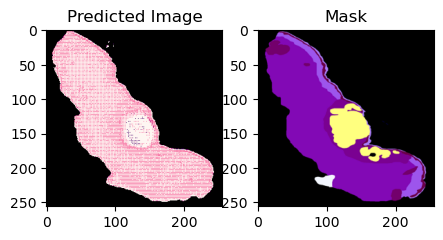

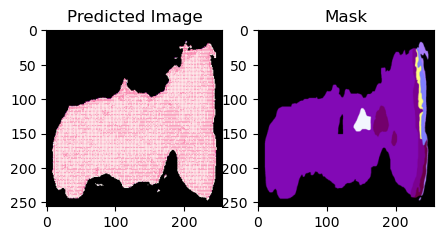

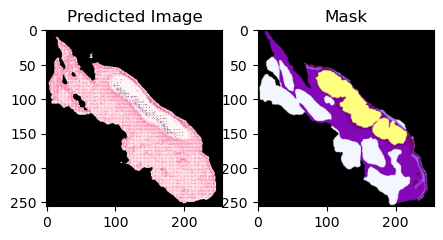

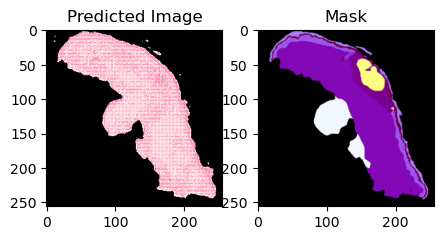

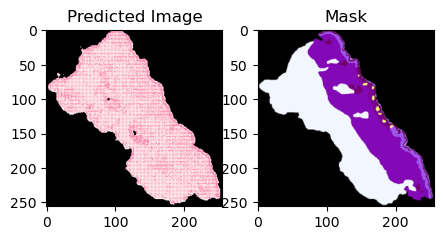

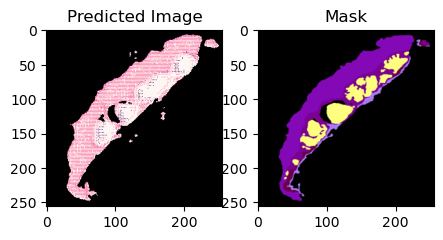

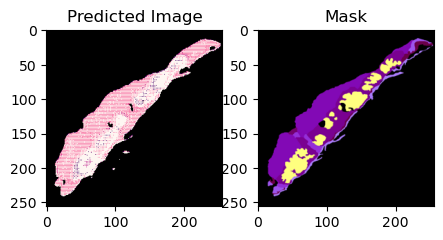

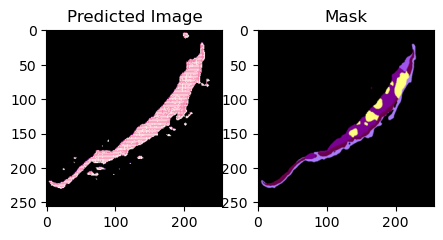

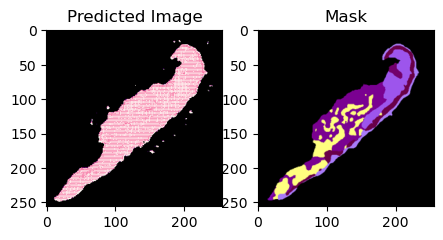

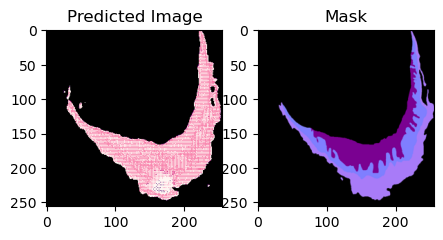

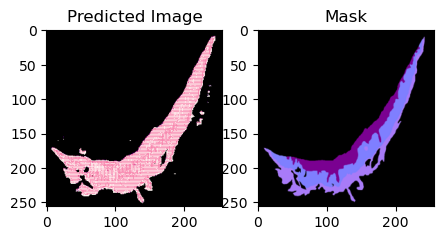

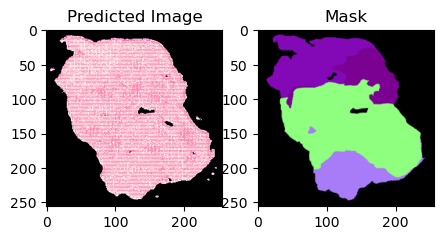

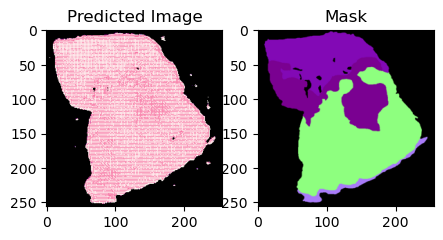

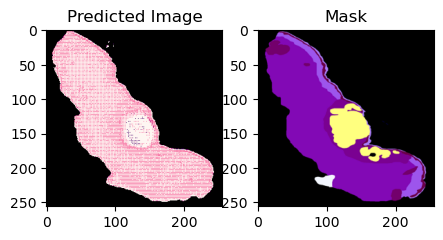

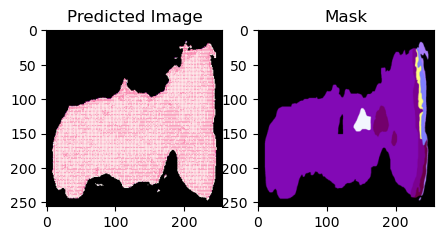

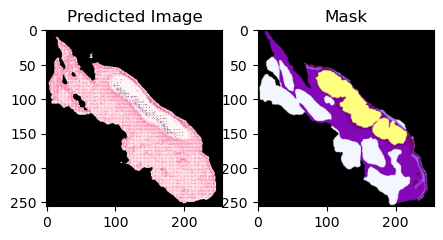

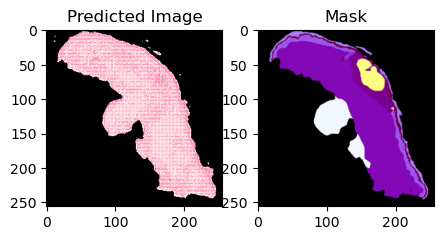

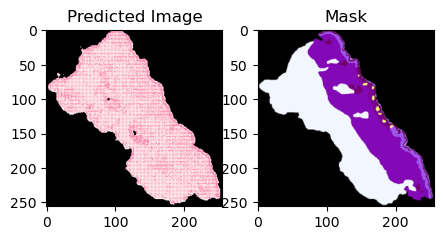

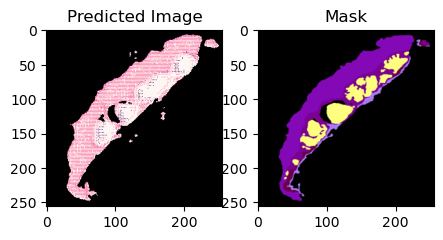

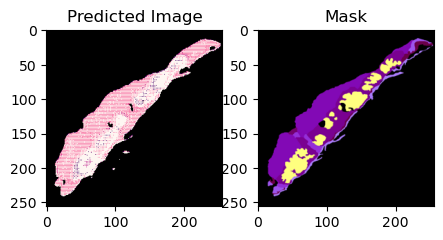

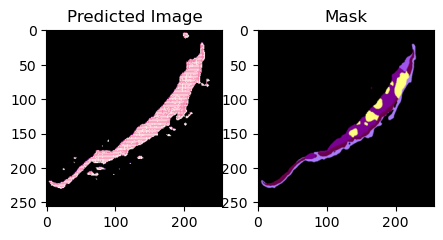

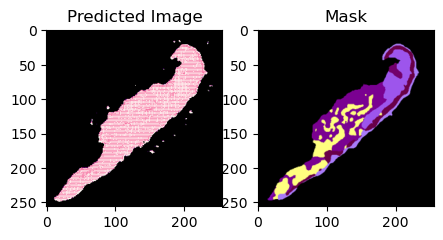

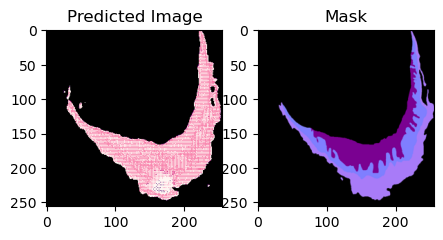

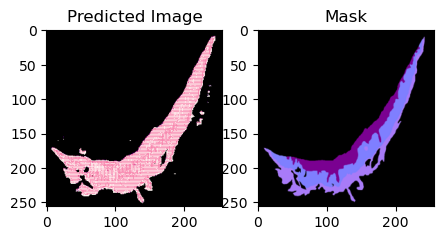

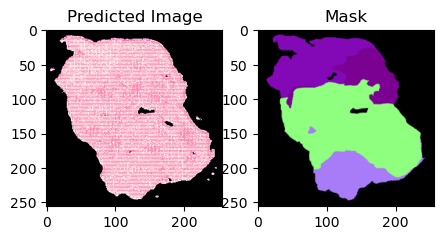

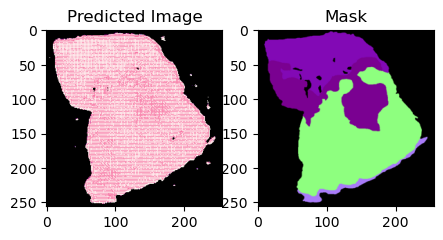

In [ ]:
for i in range(len(list_images)//4):
    fig, axs = plt.subplots(1, 2, figsize=(6, 5))
    #axs[0].imshow(list_images[i])
    #axs[0].set_title('Predict image')

    axs[0].imshow(predict_images[i*4])
    axs[0].set_title('Predicted Image')

    axs[1].imshow(masks_list[i*4])
    axs[1].set_title('Mask')
    plt.show()
